In [2]:
%matplotlib inline

import numpy as np
from scipy import stats, optimize
from matplotlib import pyplot as plt

from sklearn import gaussian_process
from sklearn.gaussian_process import kernels

import pickle
from urllib.request import urlopen

# Gaussian Processes: Part 2

## Exercise 9.1: Modeling CO₂ levels

The amount of carbon dioxide in the atmosphere has been measured continuously at the Mauna Loa observatory, Hawaii.
In this problem, you should use a Gaussian process to model the data from 1958 to 2003, and see how well that model can be used for predicting the data from 2004-2019.
They present their latest data at [their homepage](https://www.esrl.noaa.gov/gmd/ccgg/trends/), but for your convenience you can use the data in the format available [here](https://github.com/gpschool/labs/raw/2019/.resources/mauna_loa).
You can load the data with the following code snippet:

In [3]:
# download data
data = pickle.load(
    urlopen("https://github.com/gpschool/labs/raw/2019/.resources/mauna_loa")
)

# extract observations and test data
x = data['X'].flatten()
y = data['Y'].flatten()
xtest = data['Xtest'].flatten()
ytest = data['Ytest'].flatten()

Here, `x` and `y` contain your training data.

Start exploring some simple kernels, and thereafter you may have a look at page 118-122 of the book [Gaussian processes for machine learning](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf) for some inspiration on how to design a more bespoke kernel for this problem.

In [4]:
kernel = 100*kernels.RBF(length_scale=100) + kernels.WhiteKernel(noise_level=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(x[:,None], y)

/Users/emiresenov/anaconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=10**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1))

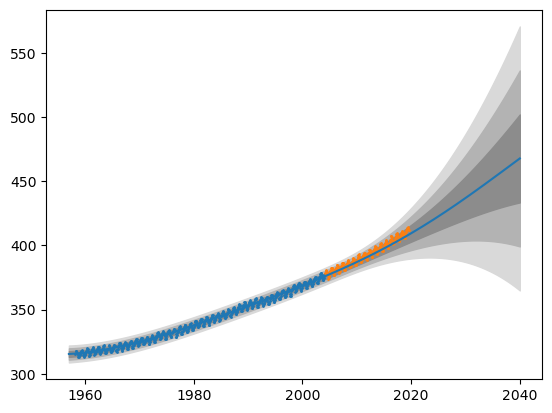

In [6]:
xs = np.linspace(1957, 2040, 200)
mu_post, std_post = gp.predict(xs[:,None], return_std=True)

plt.plot(xs,mu_post)
for i in [3,2,1]:
    plt.fill_between(
        xs,
        mu_post + i*std_post, 
        mu_post - i*std_post,
        color=str(0.4+0.15*i)
    )
    
plt.scatter(x,y,s=1)
plt.scatter(xtest, ytest, s=1)
plt.show()

## Exercise 9.2: Learning hyperparameters I


Until now, we have made GP regression using predefined hyperparameters, such as the lengthscale $\ell$ and noise variance $\sigma^2$.
In this exercise, we will estimate $\ell$ and $\sigma^2$ from the data by maximizing the marginal likelihood.
The logarithm of the marginal likelihood for a Gaussian process observed with Gaussian noise is

$$
\log p(\mathbf{y} \,|\, \mathbf{x}; \ell, \sigma_f^2, \sigma^2) = \log \mathcal{N}(\mathbf{y} \,|\, 0, \mathbf{K}_y) = -\frac{1}{2} \mathbf{y}^\mathsf{T} \mathbf{K}_y^{-1} \mathbf{y} - \frac{1}{2} \log{|\mathbf{K}_y|} - \frac{n}{2}\log{(2\pi)}
$$

where $\mathbf{K}_y = \kappa(\mathbf{x}, \mathbf{x}) + \sigma^2 \mathbf{I}$.

### (a)

Write a function that takes $\mathbf{x}$, $\mathbf{y}$, $\ell$, $\sigma_f^2$, and $\sigma^2$ as inputs and produces the logarithm of the marginal likelihood as output for the squared exponential covariance function.

In [32]:
def log_MargL(x, y, l, sf2, s2):
    n = len(x)
    Ky = sf2 * np.exp(-1/(2*l**2) * np.abs(x[:, None] - x[None, :])**2) + s2 * np.eye(n)
    _, logdet = np.linalg.slogdet(Ky)
    term = y.T@np.linalg.inv(Ky)@y + logdet + n*np.log(2*np.pi)
    return -(1/2) * term 

### (b)

Consider the same data as before. Use $\sigma_f^2 = 1$ and $\sigma^2 = 0$ and compute the logarithm of the marginal likelihood for values of $\ell$ between 0.1 and 1 and plot it.
What seems to be the maximal value of the marginal likelihood on this interval?
Do GP regression based on this value of $\ell$.

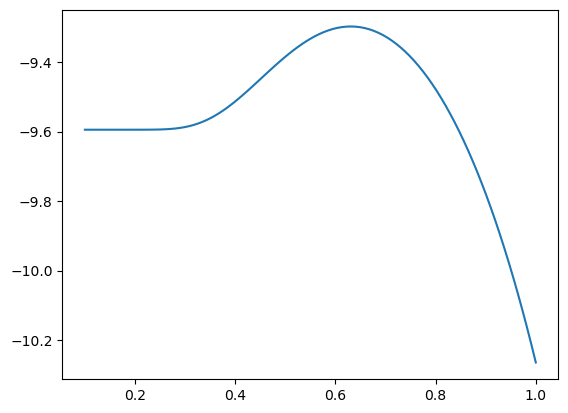

In [33]:
n = 5
x = np.array([-4,-3,-1,0,2])
y = np.array([-2,0,1,2,-1])

sf2 = 1
s2 = 0

ls = np.linspace(0.1, 1, 101)
lgl = [log_MargL(x, y, l, sf2, s2) for l in ls]

plt.plot(ls, lgl)
plt.show()

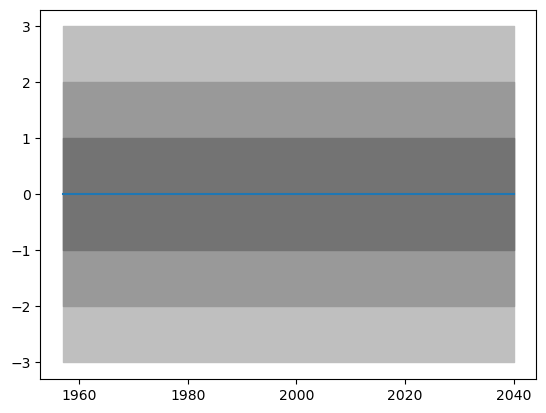

In [45]:
l = 0.63

def makeCov(x1, x2, l, sf2):
    return sf2 * np.exp(-1/(2 * l**2) * np.abs(x1[:, None] - x2[None, :])**2)

xx = makeCov(x, x, l, sf2)
xxs = makeCov(x, xs, l, sf2)
xsxs = makeCov(xs, xs, l, sf2)

C_c = xxs.T @ np.linalg.inv(xx)
mu_post = C_c @ y
K_post = xsxs - (C_c @ xxs)

plt.plot(xs, mu_post)
for i in range(3,0,-1):
    plt.fill_between(
        xs, 
        mu_post + i*np.sqrt(np.diag(K_post)), 
        mu_post - i*np.sqrt(np.diag(K_post)),
        color=str(0.3 + 0.15*i)
    )
plt.show()


## Exercise 9.3: Learning hyperparameters II

In this exercise we investigate a setting where the marginal likelihood has multiple local minima.

### (a)

Now, consider the following data

$$
\mathbf{x} = [−5, −3, 0, 0.1, 1, 4.9, 5]^\mathsf{T}, \qquad
\mathbf{y} = [0, −0.5, 1, 0.7, 0, 1, 0.7]^\mathsf{T}
$$

and compute the log marginal likelihood for both $\ell$ and $\sigma^2$.
Use a logarithmic 2D-grid for values of $\ell$ spanning from $10^{−1}$ to $10^2$ and for $\sigma^2$ spanning from $10^{−2}$ to $10^0$.
Visualize the marginal likelihood on that grid with a contour plot.

### (b)

Find the hyperparameters $\ell$ and $\sigma^2$ that correspond to the maximal marginal likelihood.
Perform GP regression on the data using these hyperparameters.

### (d)

Perform GP regression for the hyperparameters that correspond to other possible local optima of the marginal likelihood.
What differences do you see in your posterior?

## Exercise 9.4: Learning hyperparameters III

We repeat Exercise 9.3, but this time we estimate $\ell$ and $\sigma^2$ that maximize the marginal likelihood with the `fit()` function in scikit-learn automatically.
Consider the same data as in Exercise 9.3(a) and use, as before, the RBF kernel and measurement noise together.

### (a)

You still have to provide an initial value of the hyperparameters.
Try $\ell = 1$ and $\sigma^2 = 0.1$.
What hyperparameters do you get when optimizing?
Plot the corresponding mean and credibility regions.

### (b)

Try instead to initialize with $\ell = 10$ and $\sigma^2 = 1$.
What do you get now?

### (c)

Try to explain what happens by making a grid over different hyperparameter values, and inspect the marginal likelihood for each point in that grid.
The `GaussianProcessRegressor` class has a member function `log_marginal_likelihood()` which you may use.
(Do not forget to turn off the hyperparameter optimization!)